In [1]:
%matplotlib inline

## Filtering and restoration

### hysteresis thresholding
- hysterisis = the "lagging" of an effect, eg intertia
- below: compare normal to hystersis thresholding
- notice how hysteresis allows you to ignore noise outside the edges.

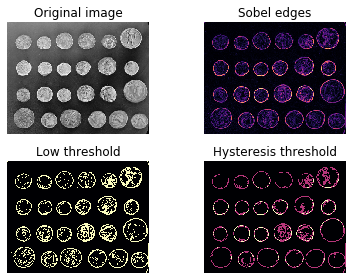

In [2]:
import matplotlib.pyplot as plt
from skimage import data, filters

image = data.coins()
edges = filters.sobel(image)
low   = 0.1
high  = 0.35
lowt  = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst  = filters.apply_hysteresis_threshold(edges, low, high)

# -----------------------------------------------------------

fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()

### image deconvolution
- below: deconvolve a noisy image using Weiner & unsupervised Weiner algos.
- algos based on linear models - can't restore sharp edges, but much faster.

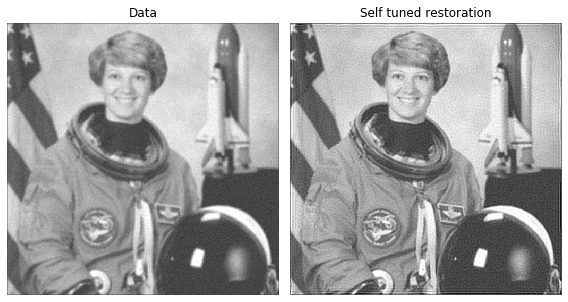

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from skimage      import color, data, restoration
from scipy.signal import convolve2d as conv2

astro          = color.rgb2gray(data.astronaut())
psf            = np.ones((5, 5)) / 25
astro          = conv2(astro, psf, 'same')
astro         += 0.1 * astro.std() * np.random.standard_normal(astro.shape)
deconvolved, _ = restoration.unsupervised_wiener(astro, psf)

# -----------------------------------------------------

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(astro, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()
plt.show()

### mean filters comparison
- _local mean_, _percentile mean_, _bilateral mean_

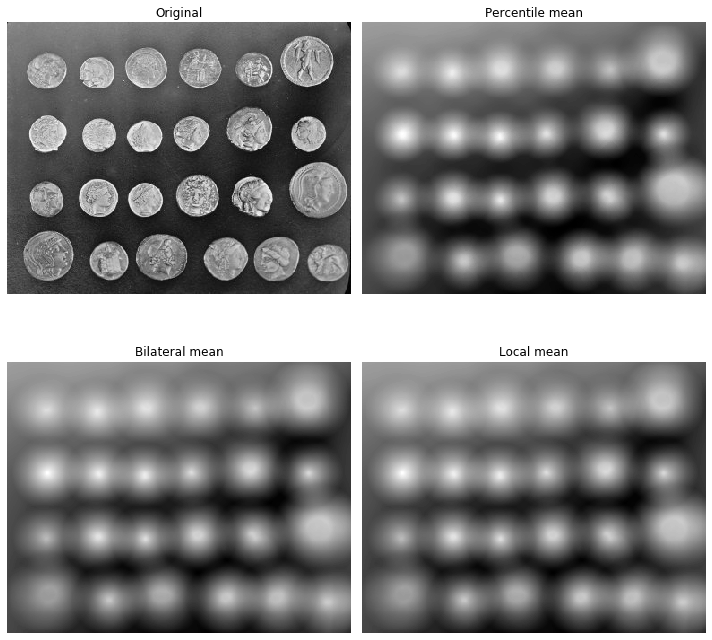

In [4]:
import matplotlib.pyplot as plt

from skimage            import data
from skimage.morphology import disk
from skimage.filters    import rank

image = data.coins()
selem = disk(20)

percentile_result = rank.mean_percentile(image, 
                                         selem=selem, 
                                         p0=.1, p1=.9)
bilateral_result  = rank.mean_bilateral(image, 
                                        selem=selem, 
                                        s0=500, s1=500)
normal_result     = rank.mean(image, 
                              selem=selem)

# ---------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

titles = ['Original', 
          'Percentile mean', 
          'Bilateral mean', 
          'Local mean']
imgs = [image, 
        percentile_result, 
        bilateral_result, 
        normal_result]

for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n], cmap=plt.cm.gray)
    ax[n].set_title(titles[n])
    ax[n].axis('off')

plt.tight_layout()
plt.show()

### unsharp masking
- linear image sharpening technique
- sharp details ID a difference btwn original & blurred versions
- enhanced = original + amount*(original-blurred)
- blurring step: typically done w/ gaussian filter
- below: comparison of different radius & amount params.

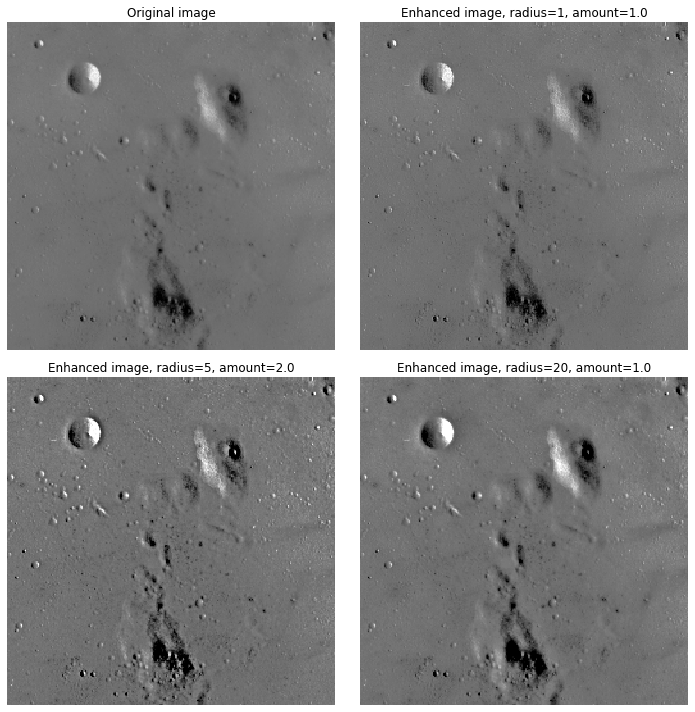

In [5]:
from skimage         import data
from skimage.filters import unsharp_mask
import matplotlib.pyplot as plt

image    = data.moon()
result_1 = unsharp_mask(image, radius=1, amount=1)
result_2 = unsharp_mask(image, radius=5, amount=2)
result_3 = unsharp_mask(image, radius=20, amount=1)

# -----------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(image,    cmap=plt.cm.gray)
ax[1].imshow(result_1, cmap=plt.cm.gray)
ax[2].imshow(result_2, cmap=plt.cm.gray)
ax[3].imshow(result_3, cmap=plt.cm.gray)

ax[0].set_title('Original image')
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].set_title('Enhanced image, radius=20, amount=1.0')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

### image deconvolution
- deconvolution done using Richardson-Lucy algo
- based on PSF (point spread function)
- PSF described as impulse response of optical system
- blurred image is sharpened via #iterations (hand tuned)

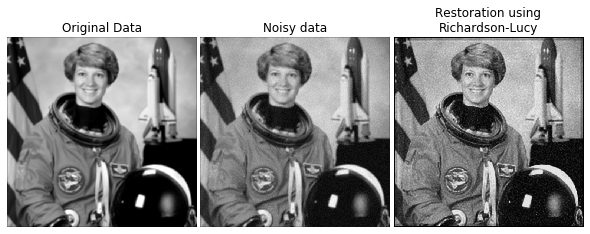

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage      import color, data, restoration

astro        = color.rgb2gray(data.astronaut())
psf          = np.ones((5, 5)) / 25
astro        = conv2(astro, psf, 'same')
astro_noisy  = astro.copy()
astro_noisy += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, 
                                             psf, 
                                             iterations=30)

# ---------------------------------------------------------

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()


### inpainting
- the process of reconstructing lost or corrupted parts of images/videos
- below: showing how masked pixels are recovered with a _biharmonic equation_.

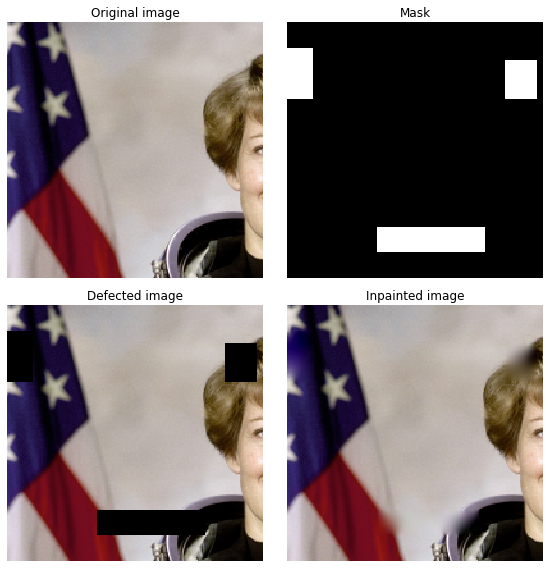

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage             import data
from skimage.restoration import inpaint

image_orig = data.astronaut()[0:200, 0:200]

# Create mask with three defect regions: left, middle, right respectively
mask                  = np.zeros(image_orig.shape[:-1])
mask[20:60, 0:20]     = 1
mask[160:180, 70:155] = 1
mask[30:60, 170:195]  = 1

# Defect image over the same region in each color channel
image_defect = image_orig.copy()

for layer in range(image_defect.shape[-1]):
    image_defect[np.where(mask)] = 0

image_result = inpaint.inpaint_biharmonic(image_defect, 
                                          mask,
                                          multichannel=True)

# ------------------------------------------------------------
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig)

ax[1].set_title('Mask')
ax[1].imshow(mask, cmap=plt.cm.gray)

ax[2].set_title('Defected image')
ax[2].imshow(image_defect)

ax[3].set_title('Inpainted image')
ax[3].imshow(image_result)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()


### entropy
- info theory: entropy = log-base-2 of the #possible outcomes for a message.
- images: local entropy related to complexity in a given neighborhood.
- entropy filter detects variations in local gray level distributions.
- 1st example: image has 2 surfaces w/ different distributions:
    - uniform random distr (-14,+14) in center
    - uniform random distr (-15,+15) at borders
- to detect central square, find local entropy measure using circular element of sufficient radius.
- 2nd example: detecting texture in camera image w/ smaller structure element.

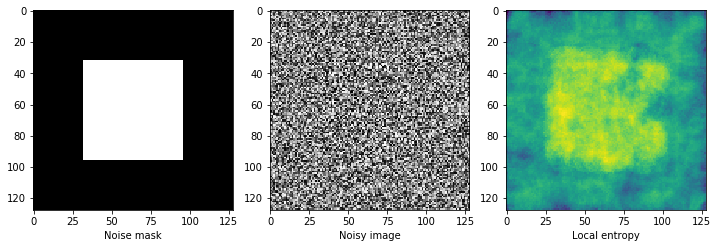

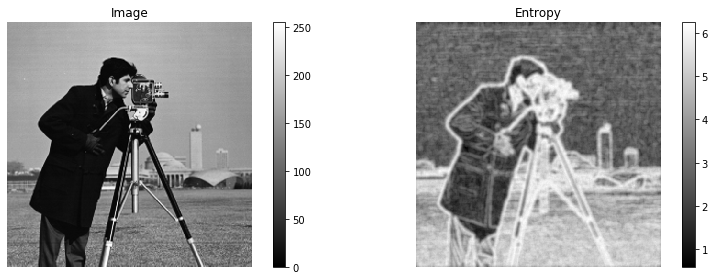

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from skimage              import data
from skimage.util         import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology   import disk

# First example: object detection.

noise_mask                 = np.full((128, 128), 28, dtype=np.uint8)
noise_mask[32:-32, 32:-32] = 30
noise                      = (noise_mask * 
                              np.random.random(noise_mask.shape) - 0.5 *
                              noise_mask).astype(np.uint8)
img                        = noise + 128
entr_img                   = entropy(img, disk(10))

# -------------------------------------------------------------------------

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax0.imshow(noise_mask, cmap='gray')
ax0.set_xlabel("Noise mask")
ax1.imshow(img, cmap='gray')
ax1.set_xlabel("Noisy image")
ax2.imshow(entr_img, cmap='viridis')
ax2.set_xlabel("Local entropy")

fig.tight_layout()

# Second example: texture detection.

image = img_as_ubyte(data.camera())

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True)

img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(entropy(image, disk(5)), cmap='gray')
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

fig.tight_layout()

plt.show()


### denoising
- _total variation filter_: returns image with minimum total variation (L1 norm of the image gradient).
- _bilateral filter_: edge preserving & noise reduction. filter. averages px based on spatial closeness & radiometric similarity.
- _wavenet denoising filter_: relies of wavelet representation of an image. color denoising using YCbCr color space.


Estimated Gaussian noise standard deviation = 0.152204381952339


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


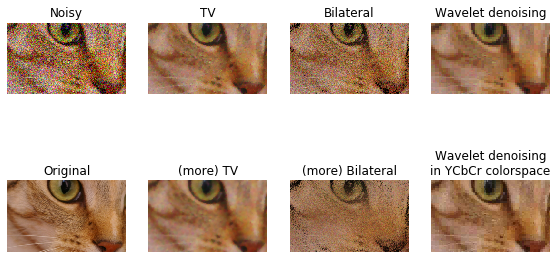

In [10]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, 
                                 denoise_bilateral,
                                 denoise_wavelet, 
                                 estimate_sigma)
from skimage             import data, img_as_float
from skimage.util        import random_noise


original = img_as_float(data.chelsea()[100:250, 50:300])
sigma    = 0.155
noisy    = random_noise(original, var=sigma**2)

# Estimate avg noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, 
                           multichannel=True, 
                           average_sigmas=True)

# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

# ------------------------------------------------------------
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, multichannel=True))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15,
                multichannel=True))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, multichannel=True, rescale_sigma=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, multichannel=True))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15,
                multichannel=True))
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                                rescale_sigma=True))
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()


### shift-invariant wavelet denoising

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


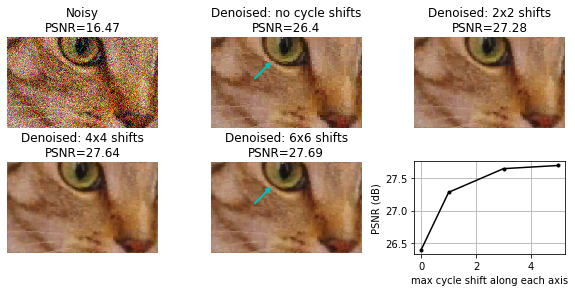

In [12]:
import matplotlib.pyplot as plt

from skimage.restoration import denoise_wavelet, cycle_spin
from skimage             import data, img_as_float
from skimage.util        import random_noise
from skimage.metrics     import peak_signal_noise_ratio

original   = img_as_float(data.chelsea()[100:250, 50:300])
sigma      = 0.155
noisy      = random_noise(original, var=sigma**2)
psnr_noisy = peak_signal_noise_ratio(original, noisy)

# ------------------------------------------------------------

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4),
                       sharex=False, sharey=False)

ax = ax.ravel()
ax[0].imshow(noisy)
ax[0].axis('off')
ax[0].set_title('Noisy\nPSNR={:0.4g}'.format(psnr_noisy))

# Repeat denosing with different amounts of cycle spinning.  e.g.
# max_shift = 0 -> no cycle spinning
# max_shift = 1 -> shifts of (0, 1) along each axis
# max_shift = 3 -> shifts of (0, 1, 2, 3) along each axis
# etc...

all_psnr       = []
max_shifts     = [0, 1, 3, 5]
denoise_kwargs = dict(multichannel=True, 
                      convert2ycbcr=True, 
                      wavelet='db1',
                      rescale_sigma=True)

for n, s in enumerate(max_shifts):
    im_bayescs = cycle_spin(noisy, 
                            func=denoise_wavelet, 
                            max_shifts=s,
                            func_kw=denoise_kwargs, 
                            multichannel=True,
                            num_workers=1)
    
    ax[n+1].imshow(im_bayescs)
    ax[n+1].axis('off')
    psnr = peak_signal_noise_ratio(original, im_bayescs)
    
    if s == 0:
        ax[n+1].set_title(
            "Denoised: no cycle shifts\nPSNR={:0.4g}".format(psnr))
    else:
        ax[n+1].set_title(
            "Denoised: {0}x{0} shifts\nPSNR={1:0.4g}".format(s+1, psnr))
    
    all_psnr.append(psnr)

# plot PSNR as a function of the degree of cycle shifting
ax[5].plot(max_shifts, all_psnr, 'k.-')
ax[5].set_ylabel('PSNR (dB)')
ax[5].set_xlabel('max cycle shift along each axis')
ax[5].grid(True)
plt.subplots_adjust(wspace=0.35, hspace=0.35)

# Annotate with a cyan arrow on the 6x6 case vs. no cycle shift case to
# illustrate a region with reduced block-like artifact with cycle shifting
arrowprops = dict(arrowstyle="simple,tail_width=0.1,head_width=0.5",
                  connectionstyle="arc3",
                  color='c')
for i in [1, 4]:
    ax[i].annotate("", xy=(101, 39), xycoords='data',
                   xytext=(70, 70), textcoords='data',
                   arrowprops=arrowprops)

plt.show()


### phase unwrapping
- recovers underlying, "unwrapped" signals
- skimage can unwrap 1D,2D,3D images; below example is 2D case.

Text(0.5, 1.0, 'Unwrapped minus original')

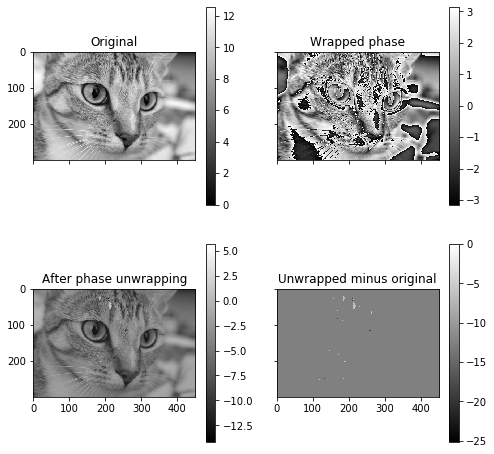

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from skimage             import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase

# Load an image as a floating-point grayscale
# Scale the image to [0, 4*pi]
# Create a phase-wrapped image in the interval [-pi, pi)
# Perform phase unwrapping

image           = color.rgb2gray(img_as_float(data.chelsea()))
image           = exposure.rescale_intensity(image, out_range=(0, 4 * np.pi))
image_wrapped   = np.angle(np.exp(1j * image))
image_unwrapped = unwrap_phase(image_wrapped)

# ------------------------------------------------------------------------------
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
ax1, ax2, ax3, ax4 = ax.ravel()

fig.colorbar(ax1.imshow(image,                 cmap='gray', vmin=0,      vmax=4 * np.pi), ax=ax1)
fig.colorbar(ax2.imshow(image_wrapped,         cmap='gray', vmin=-np.pi, vmax=np.pi),     ax=ax2)
fig.colorbar(ax3.imshow(image_unwrapped,       cmap='gray'),                              ax=ax3)
fig.colorbar(ax4.imshow(image_unwrapped-image, cmap='gray'),                              ax=ax4)

ax1.set_title('Original')
ax2.set_title('Wrapped phase')
ax3.set_title('After phase unwrapping')
ax4.set_title('Unwrapped minus original')


### non-local means denoising - for preserving textures
- "non-local": algorithm replaces px value with average of some selection of other px
- avg performed only for px with patches close to the current patch.
- result: algorithm can restore blurred textures.
- _fast_mode=False_: spatial Gaussian weighting is applied to patches
- _fast_mode=True_: uniform spatial weighting is used. (faster.)
- _sigma_: noise std deviation. expected noise variance is sub'd out. modest improvement in quality.
- _estimate_sigma_: good starting point for setting _h_ (a decay constant) & _sigma_.
- below: _h_ is hand-tuned.

estimated noise standard deviation = 0.07883187412046973
PSNR (noisy) = 22.23
PSNR (slow) = 29.40
PSNR (slow, using sigma) = 29.82
PSNR (fast) = 28.53
PSNR (fast, using sigma) = 29.31


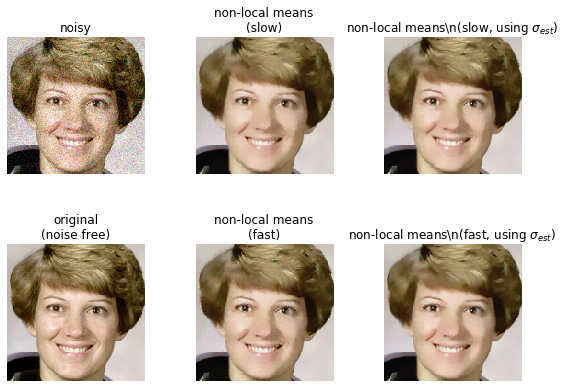

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage             import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics     import peak_signal_noise_ratio
from skimage.util        import random_noise


astro = img_as_float(data.astronaut())
astro = astro[30:180, 150:300]
sigma = 0.08
noisy = random_noise(astro, var=sigma**2)

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy, multichannel=True))
print(f"estimated noise standard deviation = {sigma_est}")

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

# slow algorithm
denoise = denoise_nl_means(noisy, 
                           h=1.15 * sigma_est, 
                           fast_mode=False,
                           **patch_kw)

# slow algorithm, sigma provided
denoise2 = denoise_nl_means(noisy, 
                            h=0.8 * sigma_est, 
                            sigma=sigma_est,
                            fast_mode=False, 
                            **patch_kw)

# fast algorithm
denoise_fast = denoise_nl_means(noisy, 
                                h=0.8 * sigma_est, 
                                fast_mode=True,
                                **patch_kw)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(noisy, 
                                 h=0.6 * sigma_est, 
                                 sigma=sigma_est,
                                 fast_mode=True, 
                                 **patch_kw)

# -------------------------------------------------------
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6),
                       sharex=True, sharey=True)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('noisy')

ax[0, 1].imshow(denoise)
ax[0, 1].axis('off')
ax[0, 1].set_title('non-local means\n(slow)')

ax[0, 2].imshow(denoise2)
ax[0, 2].axis('off')
ax[0, 2].set_title(r'non-local means\n(slow, using $\sigma_{est}$)')

ax[1, 0].imshow(astro)
ax[1, 0].axis('off')
ax[1, 0].set_title('original\n(noise free)')

ax[1, 1].imshow(denoise_fast)
ax[1, 1].axis('off')
ax[1, 1].set_title('non-local means\n(fast)')

ax[1, 2].imshow(denoise2_fast)
ax[1, 2].axis('off')
ax[1, 2].set_title(r'non-local means\n(fast, using $\sigma_{est}$)')

fig.tight_layout()

# print PSNR metric for each case
psnr_noisy = peak_signal_noise_ratio(astro, noisy)
psnr       = peak_signal_noise_ratio(astro, denoise)
psnr2      = peak_signal_noise_ratio(astro, denoise2)
psnr_fast  = peak_signal_noise_ratio(astro, denoise_fast)
psnr2_fast = peak_signal_noise_ratio(astro, denoise2_fast)

print(f"PSNR (noisy) = {psnr_noisy:0.2f}")
print(f"PSNR (slow) = {psnr:0.2f}")
print(f"PSNR (slow, using sigma) = {psnr2:0.2f}")
print(f"PSNR (fast) = {psnr_fast:0.2f}")
print(f"PSNR (fast, using sigma) = {psnr2_fast:0.2f}")

plt.show()

### attribute operators (connected operators)
- a family of contour-preserving filters
- can be implemented in max-trees - a compact hierarchical image representation.
- below: how to use _diameter closing_ vs _morphological closing_

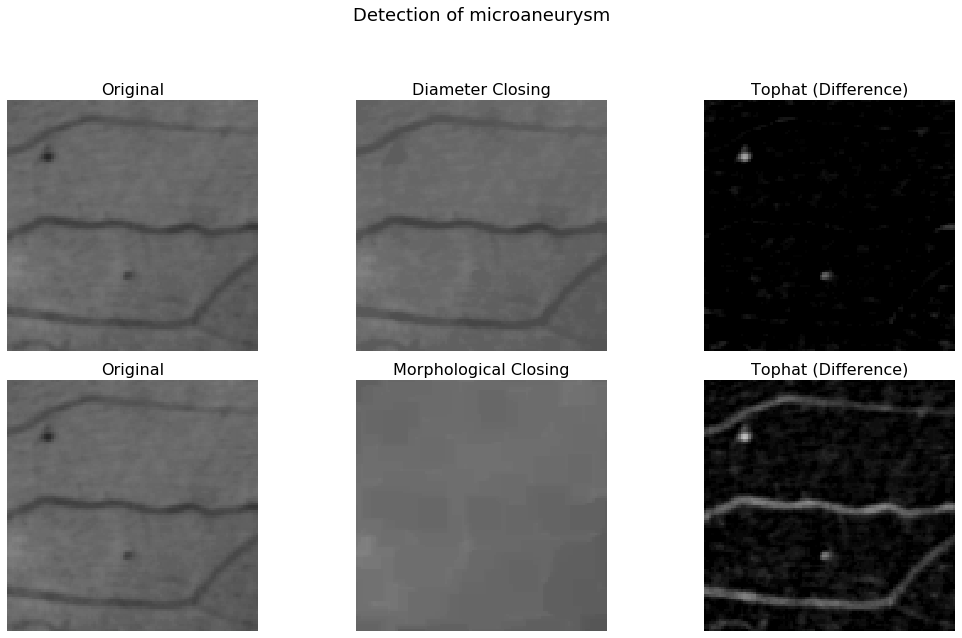

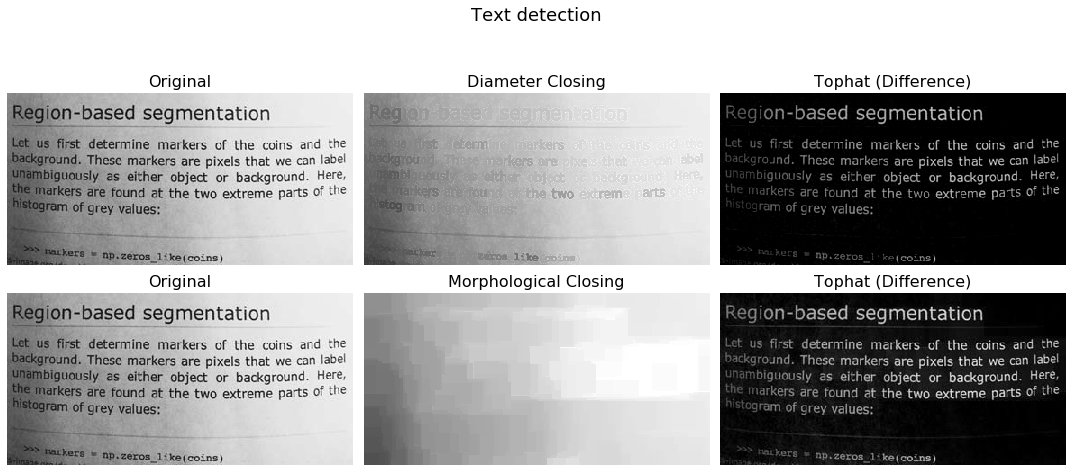

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import diameter_closing
from skimage            import data
from skimage.morphology import closing
from skimage.morphology import square

datasets = {
    'retina': {'image': data.microaneurysms(),
               'figsize': (15, 9),
               'diameter': 10,
               'vis_factor': 3,
               'title': 'Detection of microaneurysm'},
    'page': {'image': data.page(),
             'figsize': (15, 7),
             'diameter': 23,
             'vis_factor': 1,
             'title': 'Text detection'}
}

for dataset in datasets.values():
    # image with printed letters
    image = dataset['image']
    figsize = dataset['figsize']
    diameter = dataset['diameter']

    fig, ax = plt.subplots(2, 3, figsize=figsize)
    # Original image
    ax[0, 0].imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=255)
    ax[1, 0].imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=255)

    ax[0, 0].set_title('Original', fontsize=16)
    ax[1, 0].set_title('Original', fontsize=16)

    ax[0, 0].axis('off')
    ax[1, 0].axis('off')

    # Diameter closing : remove all dark structures with maximal
    # extension of less than <diameter> (12 or 23). I.e. in closed_attr, all
    # local minima have at least a maximal extension of <diameter>.
    # We then calculate the difference to the original image.

    closed_attr = diameter_closing(image, diameter, connectivity=2)
    tophat_attr = closed_attr - image

    ax[0, 1].imshow(closed_attr, 
                    cmap='gray', 
                    aspect='equal', vmin=0, vmax=255)
    ax[0, 2].imshow(dataset['vis_factor'] * tophat_attr, 
                    cmap='gray', 
                    aspect='equal', vmin=0, vmax=255)
    ax[0, 1].set_title('Diameter Closing', fontsize=16)
    ax[0, 2].set_title('Tophat (Difference)', fontsize=16)
    ax[0, 1].axis('off')
    ax[0, 2].axis('off')

    # Morphological closing: removes all dark structures that cannot
    # contain a structuring element of a certain size.
    closed = closing(image, square(diameter))
    tophat = closed - image

    ax[1, 1].imshow(closed, cmap='gray', aspect='equal',
                    vmin=0, vmax=255)
    ax[1, 1].set_title('Morphological Closing', fontsize=16)
    ax[1, 1].axis('off')

    ax[1, 2].imshow(dataset['vis_factor'] * tophat, cmap='gray',
                    aspect='equal', vmin=0, vmax=255)
    ax[1, 2].set_title('Tophat (Difference)', fontsize=16)
    ax[1, 2].axis('off')

    fig.suptitle(dataset['title'], fontsize=18)
    fig.tight_layout(rect=(0, 0, 1, 0.88))

plt.show()

### wavelet denoising
- wavelet denoising uses wavelet image representation
- Gaussian noise can be removed by setting vals<threshold = 0 (hard thresholding) or shrinkage (soft thresholding).
- below: two methods of wavelet coefficient threshold selection.
- _VisuShrink_: applies single, universal threshold to all coefficients. designed to remove Gaussian noise with high probability = often results in overly smooth images.
- _BayesShrink_: unique threshold found for each wavelet sub-band. generally better results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Estimated Gaussian noise standard deviation = 0.11763725035364053


/home/bjpcjp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


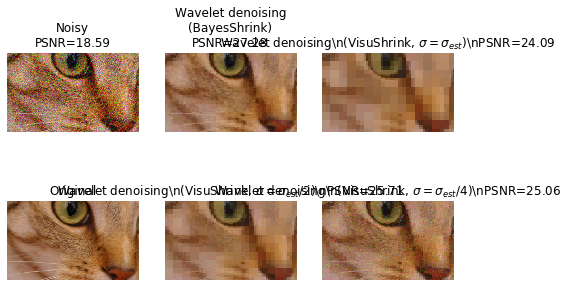

In [20]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio

original = img_as_float(data.chelsea()[100:250, 50:300])
sigma    = 0.12
noisy    = random_noise(original, var=sigma**2)
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)

im_bayes = denoise_wavelet(noisy, 
                           multichannel=True, 
                           convert2ycbcr=True,
                           method='BayesShrink', 
                           mode='soft',
                           rescale_sigma=True)

# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  Repeat, specifying a reduction
# in the threshold by factors of 2 and 4.

im_visushrink = denoise_wavelet(noisy, 
                                multichannel=True, 
                                convert2ycbcr=True,
                                method='VisuShrink', 
                                mode='soft',
                                sigma=sigma_est, 
                                rescale_sigma=True)
im_visushrink2 = denoise_wavelet(noisy, 
                                 multichannel=True, 
                                 convert2ycbcr=True,
                                 method='VisuShrink', 
                                 mode='soft',
                                 sigma=sigma_est/2, 
                                 rescale_sigma=True)
im_visushrink4 = denoise_wavelet(noisy, 
                                 multichannel=True, 
                                 convert2ycbcr=True,
                                 method='VisuShrink', 
                                 mode='soft',
                                 sigma=sigma_est/4, 
                                 rescale_sigma=True)

# --------------------------------------------------------------------------------

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")
# Compute PSNR as an indication of image quality
psnr_noisy       = peak_signal_noise_ratio(original, noisy)
psnr_bayes       = peak_signal_noise_ratio(original, im_bayes)
psnr_visushrink  = peak_signal_noise_ratio(original, im_visushrink)
psnr_visushrink2 = peak_signal_noise_ratio(original, im_visushrink2)
psnr_visushrink4 = peak_signal_noise_ratio(original, im_visushrink4)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy\nPSNR={:0.4g}'.format(psnr_noisy))

ax[0, 1].imshow(im_bayes)
ax[0, 1].axis('off')
ax[0, 1].set_title('Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0, 2].imshow(im_visushrink)
ax[0, 2].axis('off')
ax[0, 2].set_title(
    (r'Wavelet denoising\n(VisuShrink, $\sigma=\sigma_{est}$)\n'
     'PSNR=%0.4g' % psnr_visushrink))

ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

ax[1, 1].imshow(im_visushrink2)
ax[1, 1].axis('off')
ax[1, 1].set_title(
    (r'Wavelet denoising\n(VisuShrink, $\sigma=\sigma_{est}/2$)\n'
     'PSNR=%0.4g' % psnr_visushrink2))

ax[1, 2].imshow(im_visushrink4)
ax[1, 2].axis('off')
ax[1, 2].set_title(
    (r'Wavelet denoising\n(VisuShrink, $\sigma=\sigma_{est}/4$)\n'
     'PSNR=%0.4g' % psnr_visushrink4))

fig.tight_layout()
plt.show()